In [77]:
# Model Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Metric imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef,cohen_kappa_score, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

# other
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb

In [78]:
# reading in data
X_train = pd.read_csv("../data/X_train.csv").to_numpy()
X_test = pd.read_csv("../data/X_test.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()

In [79]:
# getting scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
y_train[:3] # just checking

array([0, 1, 1])

In [81]:
def print_eval(y_test, y_hat):
    print("accuracy", accuracy_score(y_test, y_hat))
    print("F1", f1_score(y_test, y_hat))
    print("recall", recall_score(y_test, y_hat))
    print("precision", precision_score(y_test, y_hat))
    print("MCC", matthews_corrcoef(y_test, y_hat))
    print("Cohen's K", cohen_kappa_score(y_test, y_hat))

### Dummy

In [82]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_y = dummy.predict(X_test)

print_eval(y_test, dummy_y)

accuracy 0.5851851851851851
F1 0.0
recall 0.0
precision 0.0
MCC 0.0
Cohen's K 0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# Anything with worse than 52% accuracy is really really bad

### Naive Bayes

In [84]:
# let's take a look at NB precision recall
nb = GaussianNB()
nb.fit(X_train, y_train) # doesn't need standardized X_train

GaussianNB()

In [85]:
Y_proba = nb.predict_proba(X_test)[:, 1] # Y_proba of positive class only

In [86]:
Y_proba

array([4.47864376e-01, 6.93901659e-01, 7.69398522e-01, 6.62162514e-01,
       5.65762936e-01, 4.66112647e-04, 4.52012236e-01, 6.19957638e-01,
       9.25344365e-01, 6.92526769e-01, 5.61428351e-01, 6.20695930e-03,
       5.60623808e-04, 1.55178132e-01, 2.58145118e-01, 6.11687546e-01,
       5.52843693e-01, 5.82538343e-01, 3.51672011e-01, 4.98935724e-01,
       6.27735949e-01, 3.04058964e-01, 2.89177243e-01, 5.40605998e-01,
       5.16509626e-01, 4.93512623e-01, 1.58438908e-02, 9.07267368e-01,
       6.35340748e-01, 3.69435957e-01, 7.39420563e-01, 3.18687825e-01,
       5.23212478e-01, 8.08575776e-02, 5.75072169e-01, 5.46114302e-01,
       4.78905128e-01, 2.49969123e-01, 2.38031891e-01, 1.73699377e-01,
       6.38329532e-01, 5.88670765e-01, 6.34326922e-01, 4.78177655e-01,
       5.98466487e-01, 5.62397863e-04, 5.02019371e-01, 2.28729380e-01,
       5.26776911e-01, 4.34617376e-03, 2.74493106e-01, 6.03214375e-01,
       8.94452522e-01, 6.56208715e-01, 6.45222131e-01, 5.26735270e-01,
      

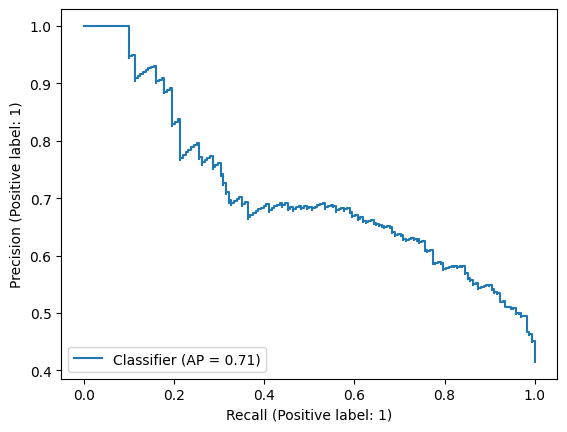

In [87]:
PrecisionRecallDisplay.from_predictions(y_test, Y_proba)

In [88]:
# 1.0 recall also gives us a reasonable precision

In [89]:
# Naive Bayes does not need tuning

In [90]:
# let's take a look at NB precision recall
nb = GaussianNB()
nb.fit(X_train, y_train) # doesn't need standardized X_train
y_pred = nb.predict(X_test)
print_eval(y_test, y_pred)

accuracy 0.6864197530864198
F1 0.6718346253229974
recall 0.7738095238095238
precision 0.593607305936073
MCC 0.3937685896285439
Cohen's K 0.3814265613161598


### Logistic Regression

In [91]:
# will need to do this a lot
def get_best_model_params(model, params):
    gs_clf = GridSearchCV(estimator=model(),
                     param_grid=params,
                     cv=5,
                     verbose=0,
                     scoring='recall')

    gs_clf.fit(X_train_scaled, y_train)

    # training the model using the best params
    bp = gs_clf.best_params_
    print(f"Best parameters found {bp}")
    return bp

In [92]:
# some combinations are not possible, so fine-tuning the LR takes some work

# In terms of solvers, it looks like liblinear and newton-cholesky are the only ones that make sense
# Liblinear is good for small datasets, while newton-cholesky is good when n_samples > n_features, per sklearn docs


# First, let's find the best functioning model for the liblinear solver
logistic_params = {"solver": ["liblinear"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l1", "l2"]}

best_params = get_best_model_params(LogisticRegression, logistic_params)
liblinear_model = LogisticRegression(**best_params)
liblinear_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = liblinear_model.predict(X_test_scaled)
print_eval(y_test, y_pred)

Best parameters found {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy 0.7753086419753087
F1 0.7073954983922829
recall 0.6547619047619048
precision 0.7692307692307693
MCC 0.531443190005338
Cohen's K 0.526935962108668


In [93]:
# But what about with newton-cholesky?
logistic_params = {"solver": ["newton-cholesky"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l2"]}


best_params = get_best_model_params(LogisticRegression, logistic_params)
newton_cholesky_model = LogisticRegression(**best_params)
newton_cholesky_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = newton_cholesky_model.predict(X_test_scaled)

print_eval(y_test, y_pred)

Best parameters found {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cholesky'}
accuracy 0.7753086419753087
F1 0.7073954983922829
recall 0.6547619047619048
precision 0.7692307692307693
MCC 0.531443190005338
Cohen's K 0.526935962108668


In [94]:
# But what about with sag?
logistic_params = {"solver": ["sag"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l1","l2"]}


best_params = get_best_model_params(LogisticRegression, logistic_params)
sag_model = LogisticRegression(**best_params)
sag_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = sag_model.predict(X_test_scaled)

print_eval(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Best parameters found {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
accuracy 0.7753086419753087
F1 0.7073954983922829
recall 0.6547619047619048
precision 0.7692307692307693
MCC 0.531443190005338
Cohen's K 0.526935962108668


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.

In [95]:
# But what about with saga?
logistic_params = {"solver": ["saga"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l1","l2"]}


best_params = get_best_model_params(LogisticRegression, logistic_params)
saga_model = LogisticRegression(**best_params)
saga_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = saga_model.predict(X_test_scaled)

print_eval(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Best parameters found {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
accuracy 0.7753086419753087
F1 0.7073954983922829
recall 0.6547619047619048
precision 0.7692307692307693
MCC 0.531443190005338
Cohen's K 0.526935962108668


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [96]:
# check SAG & SAGA - results aren't good. and the model isn't converging, which is apparent from the warnings.

In [97]:
# Other solvers don't make sense to investigate. Let's look at precision-recall for liblinear_model. It did better on Recall, the target metric

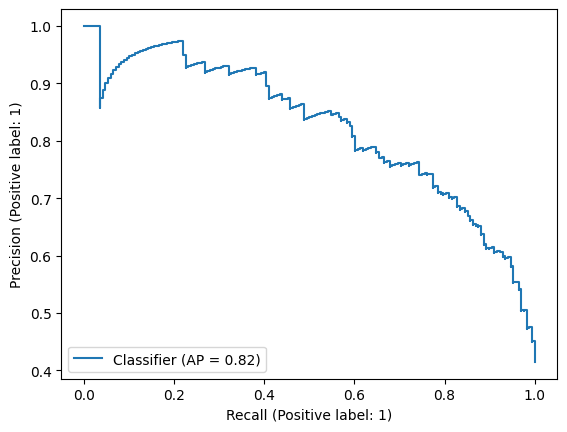

In [98]:
Y_prob_preds = liblinear_model.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

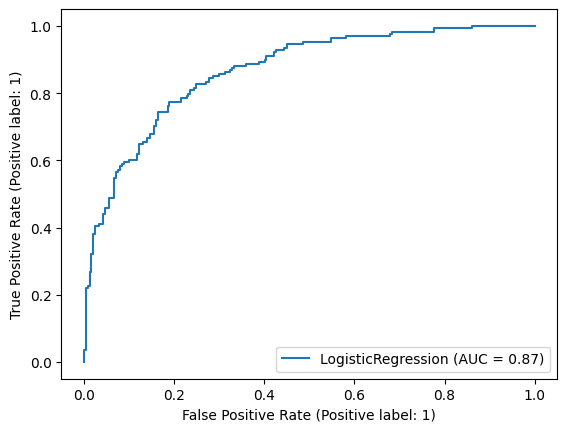

In [99]:
# ROC
RocCurveDisplay.from_estimator(liblinear_model, X_test_scaled, y_test)

### KNN

Best parameters found {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
accuracy 0.7185185185185186
F1 0.6666666666666666
recall 0.6785714285714286
precision 0.6551724137931034
MCC 0.42340180056549076
Cohen's K 0.4232066561727007


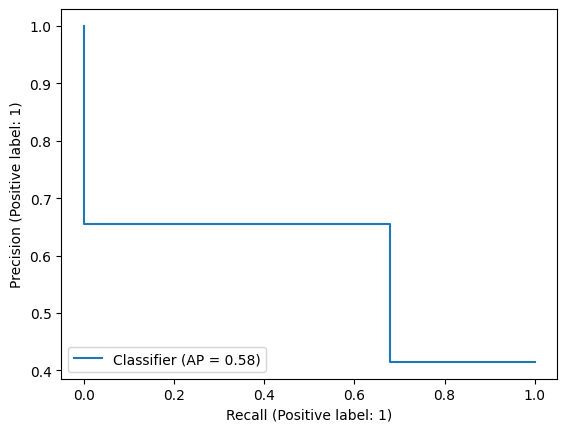

In [100]:
KNN_params = {"n_neighbors": [1, 3, 5, 7, 9, 11, 15],
                  "weights": ['uniform', 'distance'],
                  "p": [1, 2]}
best_params = get_best_model_params(KNeighborsClassifier, KNN_params)
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = knn.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

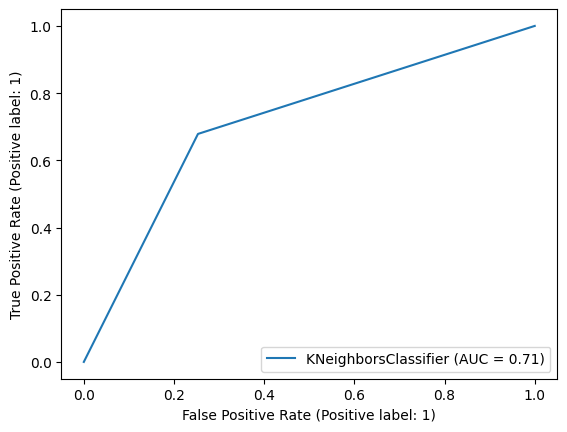

In [101]:
# ROC
RocCurveDisplay.from_estimator(knn, X_test_scaled, y_test)

### Support Vector Machine

Best parameters found {'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
accuracy 0.7728395061728395
F1 0.6933333333333334
recall 0.6190476190476191
precision 0.7878787878787878
MCC 0.5265203514382454
Cohen's K 0.5170321978534764


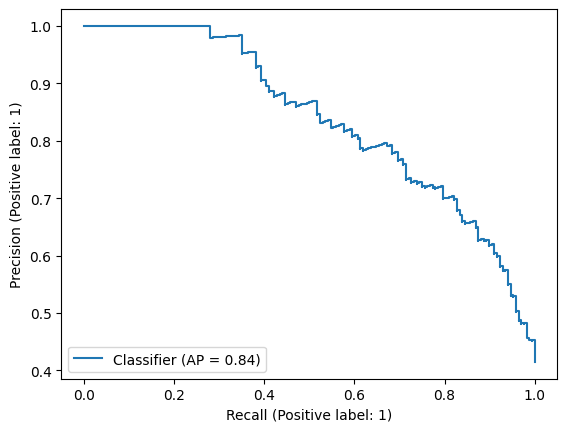

In [102]:
SVC_params = {"C": [1.0, 0.1, 0.01, 0.001, 0.0001],
             "gamma": ["scale", "auto"], 
             "degree": [1, 2, 3, 4], 
             "kernel": ["linear", "poly", "rbf", "sigmoid"]}
best_params = get_best_model_params(SVC, SVC_params)
svc_model = SVC(**best_params, probability=True)
svc_model.fit(X_train_scaled, y_train)

y_pred = svc_model.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = svc_model.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

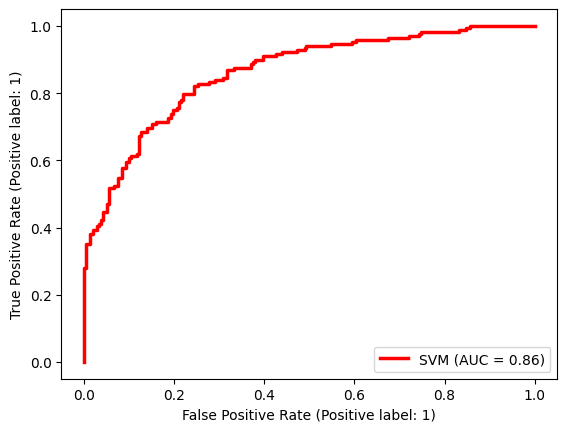

In [103]:
# ROC
RocCurveDisplay.from_estimator(svc_model, X_test_scaled, y_test, name="SVM", color="red", linewidth=2.5)

### Decision Tree Classifier

Best parameters found {'criterion': 'gini', 'max_depth': 7}
accuracy 0.7382716049382716
F1 0.6787878787878788
recall 0.6666666666666666
precision 0.691358024691358
MCC 0.4582933750642206
Cohen's K 0.4580777096114519


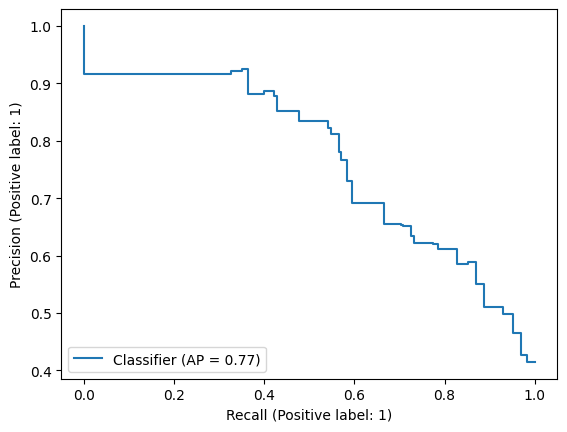

In [104]:
DT_params = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 3, 5, 7, 9]
    }
best_params = get_best_model_params(DecisionTreeClassifier, DT_params)
DT = DecisionTreeClassifier(**best_params)
DT.fit(X_train_scaled, y_train)

y_pred = DT.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = DT.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

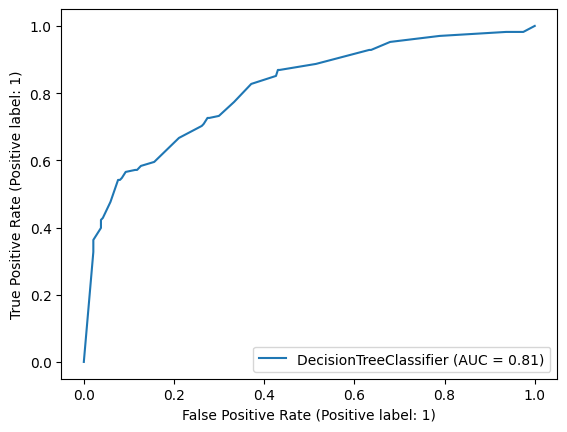

In [105]:
# ROC
RocCurveDisplay.from_estimator(DT, X_test_scaled, y_test)

### Random Forest

Best parameters found {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 25}
accuracy 0.8419753086419753
F1 0.7922077922077921
recall 0.7261904761904762
precision 0.8714285714285714
MCC 0.6736220299313438
Cohen's K 0.6664092664092665


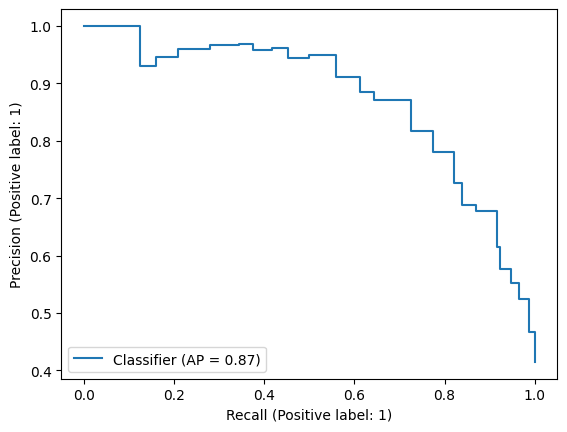

In [106]:
RF_params = {
        "n_estimators": [25, 50, 100, 150],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 3, 5, 7, 9]
}
best_params = get_best_model_params(RandomForestClassifier, RF_params)
RF = RandomForestClassifier(**best_params)
RF.fit(X_train_scaled, y_train)

y_pred = RF.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = RF.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

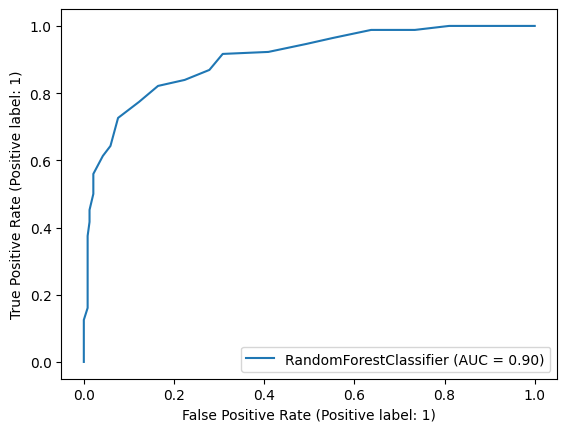

In [107]:
# ROC
RocCurveDisplay.from_estimator(RF, X_test_scaled, y_test)

### XGBoost

Best parameters found {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'binary:logistic'}
accuracy 0.8074074074074075
F1 0.7531645569620253
recall 0.7083333333333334
precision 0.8040540540540541
MCC 0.5995247552322123
Cohen's K 0.5963042478147523


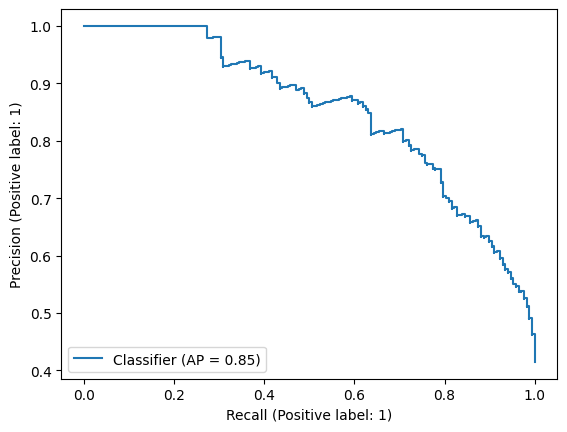

In [108]:
xgb_params = {
        "n_estimators": [100, 200, 500, 1000],
        "learning_rate": [0.0001,0.01,0.1],
        "objective": ["binary:logistic"],
        "max_depth": [None, 3, 7, 9],
        "gamma": [0,0.1,0.7,1]
}
best_params = get_best_model_params(xgb.XGBClassifier, xgb_params)
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = xgb_model.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

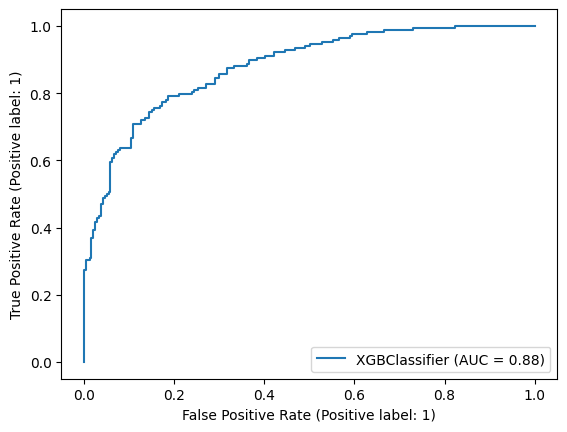

In [109]:
# ROC
RocCurveDisplay.from_estimator(xgb_model, X_test_scaled, y_test)

In [110]:
import matplotlib.pyplot as plt
# plotting all roc on the same graph

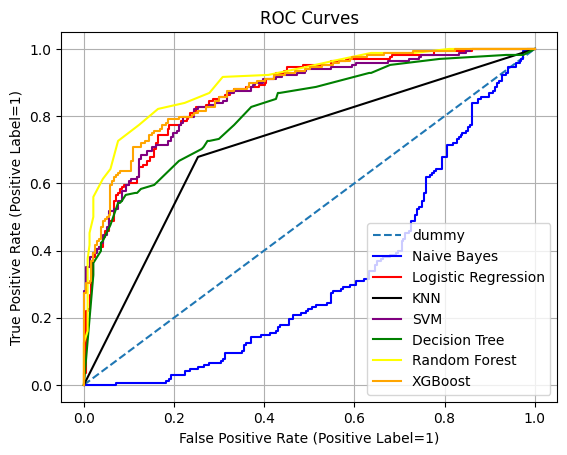

In [111]:
# getting dummy first
scores = dummy.predict_proba(X_test_scaled)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, scores, pos_label=1)
plt.plot(fprs, tprs, '--')


models = [nb, liblinear_model, knn, svc_model, DT, RF, xgb_model]
colors = ['blue', 'red', 'black', 'purple', 'green', 'yellow', 'orange']
for model, color in zip(models, colors):
    scores = model.predict_proba(X_test_scaled)[:, 1]
    fprs, tprs, thresholds = roc_curve(y_test, scores, pos_label=1)
    plt.plot(fprs, tprs, color=color)
plt.legend(['dummy', 'Naive Bayes', 'Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest','XGBoost'])
plt.grid()
plt.title('ROC Curves')
plt.xlabel('False Positive Rate (Positive Label=1)')
plt.ylabel('True Positive Rate (Positive Label=1)')
plt.show()

### Comparing Metrics & Getting visualization

In [138]:
ours = pd.read_csv("../metrics/classical_models.csv")
replication = pd.read_csv("../metrics/replication.csv")

In [139]:
# manually adding their reported data

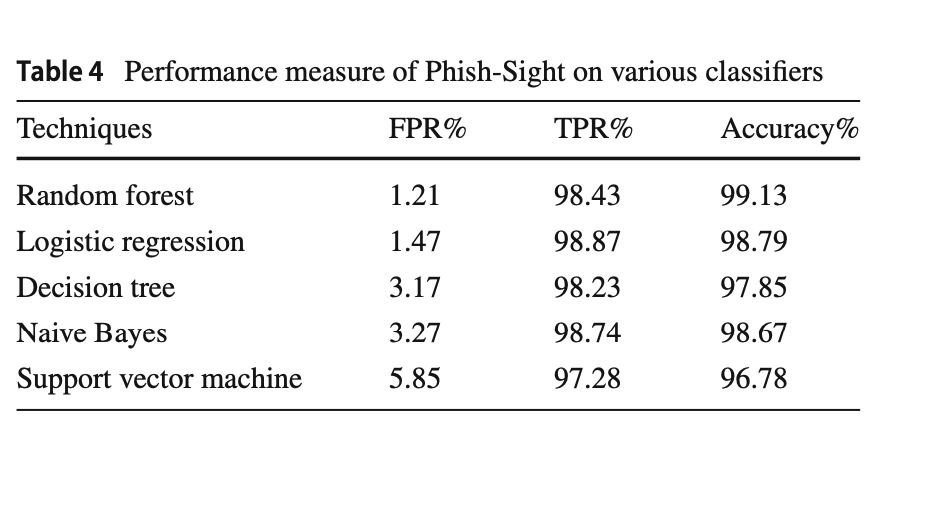

In [140]:
reported = [
    ("Random forest", 1.21, 98.43, 99.13),
    ("Logistic Regression", 1.47, 98.87, 98.79),
    ("Decision Tree", 3.17, 97.28, 96.78),
    ("Naive Bayes", 3.27, 98.74, 98.67),
    ("SVM", 5.85, 97.28, 96.78)
]
reported = pd.DataFrame(data=reported, columns = ["model","fpr", "recall", "accuracy"])

In [141]:
reported.sort_values

<bound method DataFrame.sort_values of                  model   fpr  recall  accuracy
0        Random forest  1.21   98.43     99.13
1  Logistic Regression  1.47   98.87     98.79
2        Decision Tree  3.17   97.28     96.78
3          Naive Bayes  3.27   98.74     98.67
4                  SVM  5.85   97.28     96.78>

In [142]:
# dropping some unneeded metrics
ours = ours.drop(labels=["Precision", "Matthews correlation coefficient (MCC)", "F1", "Kappa Coefficient", "Unnamed: 0"], axis=1)
# dropping KNN, can't compare it
ours = ours.drop(index=[5], axis=0)

In [143]:
ours['Model'][1] = 'Naive Bayes' # renaming for alphabetical order to work

/var/folders/zc/g0w96sh55bq1w03tz36mmk940000gn/T/ipykernel_33557/2012009230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ours['Model'][1] = 'Naive Bayes' # renaming for alphabetical order to work


In [144]:
ours = ours.sort_values('Model')
ours

,Model,Accuracy,Recall,FPR
3,DecisionTreeClassifier,0.738272,0.666667,0.210970
0,LogisticRegression,0.775309,0.654762,0.139241
1,Naive Bayes,0.639506,0.148810,0.012658
4,RandomForestClassifier,0.817284,0.678571,0.084388
2,SVC,0.772840,0.619048,0.118143


In [145]:
replication = replication.sort_values('model')
replication

,model,accuracy,fpr,recall
3,Decicion Tree,0.771147,0.303448,0.832545
1,Logistic Regression,0.628957,0.602299,0.819300
0,Naive Bayes,0.619097,0.600000,0.799432
4,Random Forest,0.830825,0.145977,0.811731
2,SVM,0.687078,0.401149,0.759697


In [146]:
reported = reported.sort_values('model')
reported

,model,fpr,recall,accuracy
2,Decision Tree,3.17,97.28,96.78
1,Logistic Regression,1.47,98.87,98.79
3,Naive Bayes,3.27,98.74,98.67
0,Random forest,1.21,98.43,99.13
4,SVM,5.85,97.28,96.78


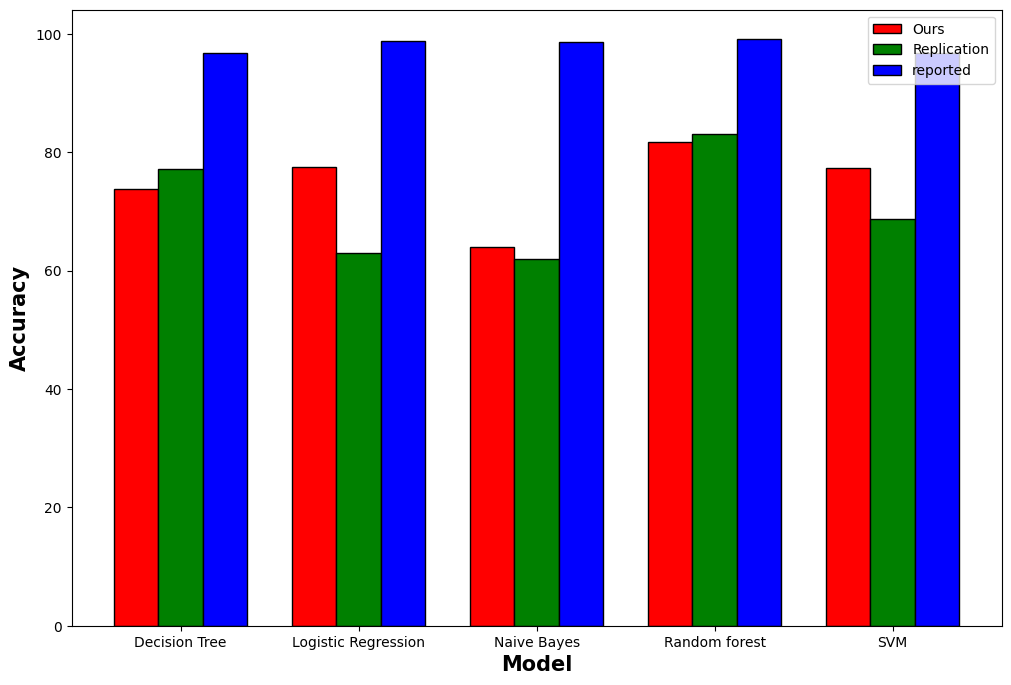

In [147]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
our_acc = [a*100 for a in ours['Accuracy']] # making it a percentage
replic_acc = [a*100 for a in replication['accuracy']]
reported_acc = reported['accuracy']

# Set position of bar on X axis
br1 = [x for x in np.arange(len(our_acc))]
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

assert len(br1) == len(br2) == len(br3)
assert len(our_acc) == len(replic_acc) == len(reported_acc)

# Make the plot
plt.bar(br1, our_acc, color ='red', width = barWidth, edgecolor ='black', label ='Ours')
plt.bar(br2, replic_acc, color ='green', width = barWidth, edgecolor ='black', label ='Replication')
plt.bar(br3, reported_acc, color ='blue', width = barWidth, edgecolor ='black', label ='reported')

# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(our_acc))], ['Decision Tree', 'Logistic Regression', 'Naive Bayes', 'Random forest', 'SVM'])

plt.legend()
plt.show()

In [148]:
# we should do one for recall too

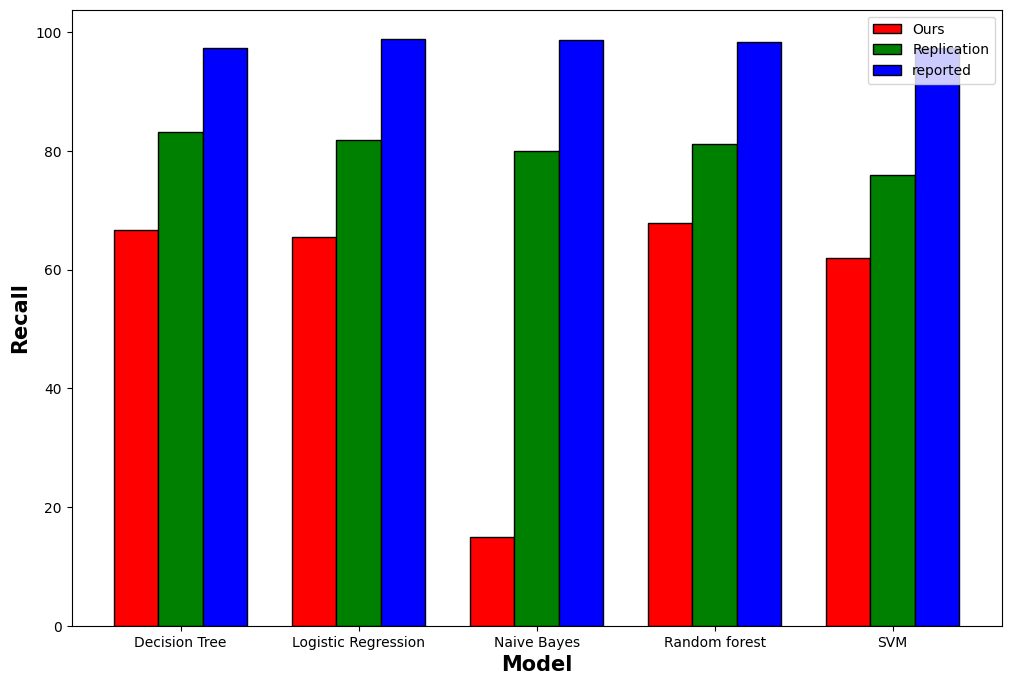

In [149]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
our_recall = [a*100 for a in ours['Recall']] # making it a percentage
replic_recall = [a*100 for a in replication['recall']]
reported_recall = reported['recall']

# Set position of bar on X axis
br1 = np.arange(len(our_acc))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, our_recall, color ='red', width = barWidth, edgecolor ='black', label ='Ours')
plt.bar(br2, replic_recall, color ='green', width = barWidth, edgecolor ='black', label ='Replication')
plt.bar(br3, reported_recall, color ='blue', width = barWidth, edgecolor ='black', label ='reported')

# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Recall', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(our_recall))], ['Decision Tree', 'Logistic Regression', 'Naive Bayes', 'Random forest', 'SVM'])

plt.legend()
plt.show()